In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from datasets.cityscapes import Cityscapes
from datasets.bdd100k import BDD100KSeg
from datasets.road_anomaly import RoadAnomaly
from datasets.fishyscapes import FishyscapesLAF, FishyscapesStatic
from datasets.segment_me_if_you_can import RoadAnomaly21, RoadObstacle21
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm

from train_net import Trainer, setup
from detectron2.checkpoint import DetectionCheckpointer

from analysis.max_logits import MaxLogitsAnalyzer, OODEvaluator

import vis_utils as vis

In [4]:
plt.rcParams['axes.grid'] = False
plt.rcParams['image.cmap'] = 'viridis'

# PATHS

In [6]:
config_path_swin_b_in21k = './configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_base_IN21k_384_bs16_90k.yaml'
config_path_swin_l_in21k = './configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_large_IN21k_384_bs16_90k.yaml'
config_path_swin_s = 'configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_small_bs16_90k.yaml'
config_path_swin_t = 'configs/cityscapes/semantic-segmentation/swin/maskformer2_swin_tiny_bs16_90k.yaml'
config_path_r101 = './configs/cityscapes/semantic-segmentation/maskformer2_R101_bs16_90k.yaml'


ckpt_path_swin_b_in21k = './pretrained/swin_b_in21k_model_final_1c6b65.pkl'
ckpt_path_swin_l_in21k = './pretrained/swin_l_in21k_model_final_17c1ee.pkl'
ckpt_path_swin_s = './pretrained/swin_s_model_final_fa26ae.pkl'
ckpt_path_swin_t = './pretrained/swin_t_model_final_2d58d4.pkl'
ckpt_path_r101 = './pretrained/r101_model_final_257ce8.pkl'

config_paths = {
    'r101': config_path_r101,
    'swin_t': config_path_swin_t,
    'swin_s': config_path_swin_s,
    'swin_b': config_path_swin_b_in21k,
    'swin_l': config_path_swin_l_in21k,
}

ckpt_paths = {
    'r101': ckpt_path_r101,
    'swin_t': ckpt_path_swin_t,
    'swin_s': ckpt_path_swin_s,
    'swin_b': ckpt_path_swin_b_in21k,
    'swin_l': ckpt_path_swin_l_in21k
}

In [7]:
def load_model_state_dict(path):
    with open(path, 'rb') as f:
        state_dict = pickle.load(f)
    
    return state_dict['model']

def get_model(name):
    
    args = edict({'config_file': config_paths[name], 'eval-only':True, 'opts':[]})
    config = setup(args)

    ckpt = load_model_state_dict(ckpt_paths[name])
    model = Trainer.build_model(config)
    DetectionCheckpointer(model, save_dir=config.OUTPUT_DIR).resume_or_load(
        ckpt_paths[name], resume=False
    )
    model.cuda()
    _ = model.eval()
    
    return model

# Params

In [8]:
image_mean = [123.675, 116.280, 103.530]
image_std = [58.395, 57.120, 57.375]

# Dataset Configs

In [9]:
bdd100k_config = edict({
    'seg_downsample_rate': 1,
    'train_file': 'train_paths.txt',
    'val_file': 'val_paths.txt',
    'val_image_strategy': 'no_change',
    'ignore_train_class': True,
    'dataset_root': '/media/nazirnayal/DATA/datasets/bdd100k/seg'
})

cityscapes_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/cityscapes',
})

road_anomaly_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/RoadAnomaly/RoadAnomaly_jpg',
    'test_image_strategy': 'no_change'
})

fishyscapes_laf_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/Fishyscapes/',
})

fishyscapes_static_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/Fishyscapes/',
})

road_anomaly_21_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/SegmentMeIfYouCan/dataset_AnomalyTrack',
    'dataset_mode': 'all'
})

road_obstacle_21_config = edict({
    'dataset_root': '/media/nazirnayal/DATA/datasets/SegmentMeIfYouCan/dataset_ObstacleTrack',
    'dataset_mode': 'all'
})



# Create Datasets

In [10]:
# Cityscapes
transform = A.Compose([
    ToTensorV2()
])
cityscapes_dataset = Cityscapes(cityscapes_config, transform=transform, split='val', 
                                target_type='semantic')
loader_cityscapes = DataLoader(cityscapes_dataset, batch_size=1, shuffle=False, num_workers=15)

# BDD100K
transform_bdd100k = A.Compose([
    ToTensorV2(),
])
bdd100k_dataset = BDD100KSeg(hparams=bdd100k_config, mode='val', transforms=transform_bdd100k, 
                             image_size=(720, 1280))
loader_bdd100k = DataLoader(bdd100k_dataset, batch_size=1, shuffle=False, num_workers=15)
# Road Anomaly
transform_road_anomaly = A.Compose([
    ToTensorV2()
])
road_anomaly_dataset = RoadAnomaly(hparams=road_anomaly_config, transforms=transform_road_anomaly)
loader_road_anomaly = DataLoader(road_anomaly_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes LaF
transform_fs_laf = A.Compose([
    ToTensorV2()
])
fs_laf_dataset = FishyscapesLAF(hparams=fishyscapes_laf_config, transforms=transform_fs_laf)
loader_fs_laf = DataLoader(fs_laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes Static
transform_fs_static = A.Compose([
    ToTensorV2()
])
fs_static_dataset = FishyscapesStatic(hparams=fishyscapes_static_config, transforms=transform_fs_static)
loader_fs_static = DataLoader(fs_static_dataset, batch_size=1, shuffle=False, num_workers=15)

# Road Anomaly 21
transform_ra_21 = A.Compose([
    A.Resize(height=720, width=1280),
    ToTensorV2()
])
road_anomaly_21_dataset = RoadAnomaly21(hparams=road_anomaly_21_config, transforms=transform_ra_21)
loader_road_anomaly_21 = DataLoader(road_anomaly_21_dataset, batch_size=1, shuffle=False, num_workers=15)


# Util Functions

In [11]:
def get_logits(model, x, **kwargs):
    
    with torch.no_grad():
        out = model([{"image": x[0].cuda()}], **kwargs)
    
    if kwargs['return_separately']:
        return out[0][0]['sem_seg'].unsqueeze(0), out[1], out[2]
    
    return out[0]['sem_seg'].unsqueeze(0)

In [36]:
model_swin_b = get_model('swin_b')

WARNING [07/27 18:12:40 fvcore.common.config]: Loading config ./configs/cityscapes/semantic-segmentation/swin/../Base-Cityscapes-SemanticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
[07/27 18:12:40 detectron2]: Rank of current process: 0. World size: 1
[07/27 18:12:40 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
numpy                   1.19.0
detectron2              0.6 @/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.3
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.10.0+cu113 @/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-pa

[07/27 18:12:40 detectron2]: Full config saved to ./output/config.yaml
[07/27 18:12:40 d2.utils.env]: Using a generated random seed 40888153
[07/27 18:12:41 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
         

[07/27 18:12:41 fvcore.common.checkpoint]: [Checkpointer] Loading from ./pretrained/swin_b_in21k_model_final_1c6b65.pkl ...
[07/27 18:12:41 fvcore.common.checkpoint]: Reading a file from 'MaskFormer Model Zoo'
WARNING [07/27 18:12:41 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


In [12]:
torch.cuda.is_available()

True

# Examining void class

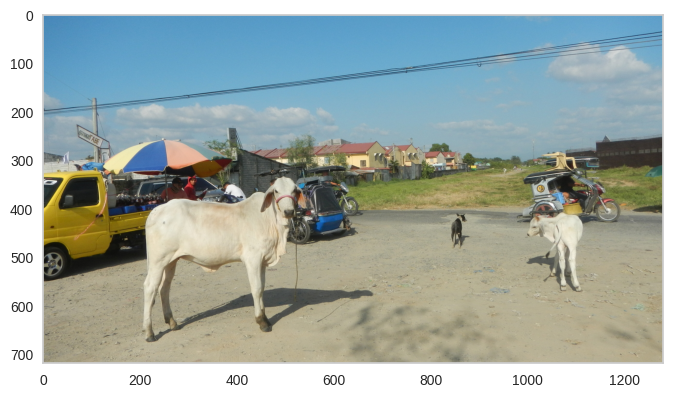

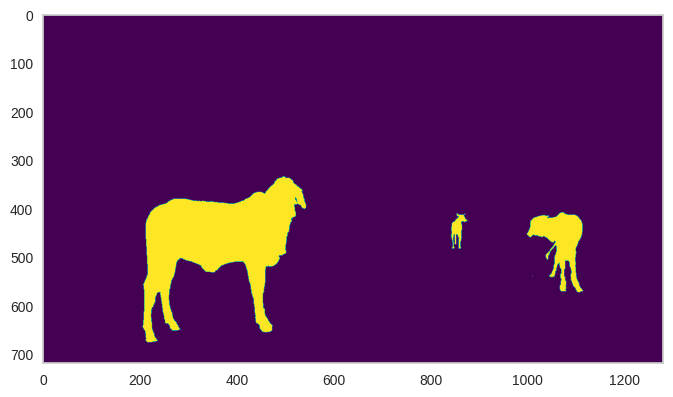

In [81]:
img, lbl = road_anomaly_dataset[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

plt.imshow(lbl)
plt.show()

In [82]:
logits = get_logits(model_swin_l, img.unsqueeze(0), include_void=True)

KeyError: 'return_separately'

In [105]:
logits.shape

torch.Size([1, 20, 720, 1280])

In [106]:
max_logit = logits[:,:19,:,:].max(dim=1).values

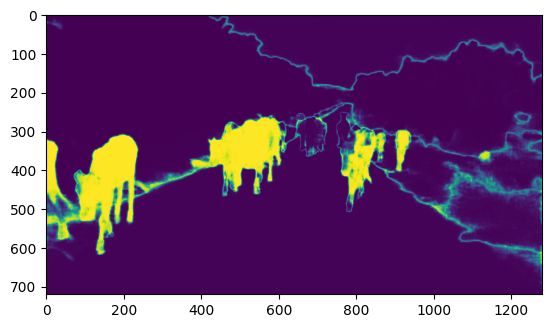

In [107]:
plt.imshow(-max_logit.cpu().squeeze())
plt.show()

In [108]:
void_logit = logits[:, 19]

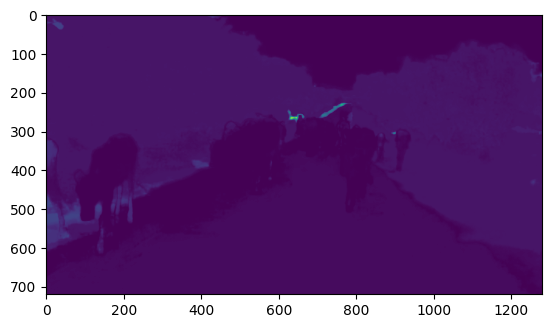

In [109]:
plt.imshow(void_logit.cpu().squeeze())
plt.show()

In [110]:
void_logit[0, 450, 400], void_logit[0, 700, 600]

(tensor(0.0028, device='cuda:0'), tensor(1.0008, device='cuda:0'))

In [67]:
void_logit.max(), void_logit.min()

(tensor(19.9151, device='cuda:0'), tensor(6.8911e-08, device='cuda:0'))

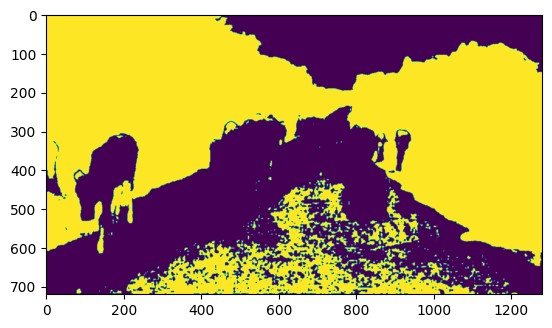

In [111]:
mask = void_logit > 1
k = torch.zeros_like(void_logit)
k[mask] = 1.0
plt.imshow(k.cpu().squeeze())
plt.show()

# Examining Region Masks and Probs.

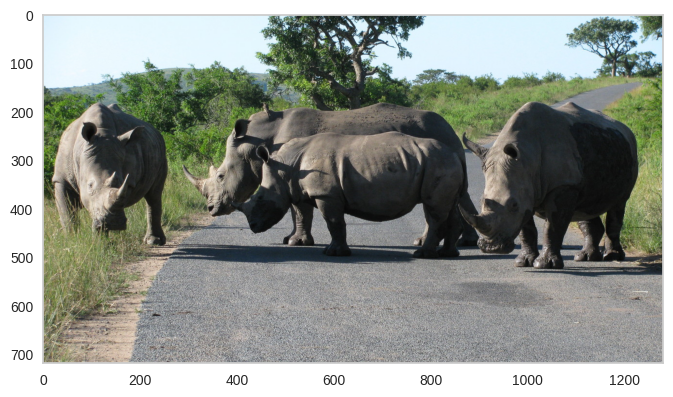

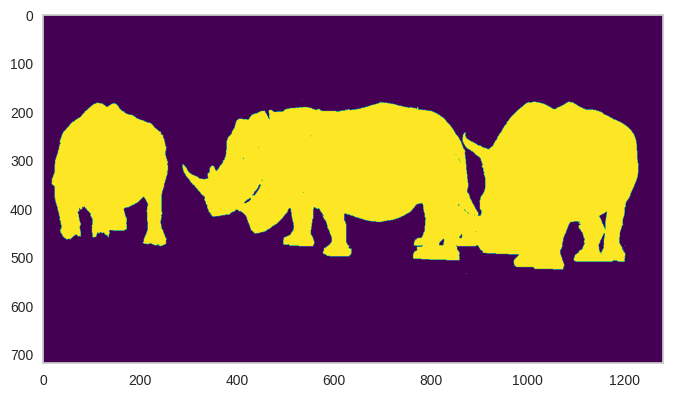

In [142]:
img, lbl = road_anomaly_dataset[22]

# img, lbl = bdd100k_dataset[442]

plt.imshow(img.permute(1, 2, 0))
plt.show()

plt.imshow(lbl)
plt.show()

In [143]:
logits, prob_logits, mask_logits = get_logits(model_swin_l, img.unsqueeze(0), include_void=True, 
                                              return_separately=True)

In [144]:
logits.shape, mask_logits.shape, prob_logits.shape

(torch.Size([1, 20, 720, 1280]),
 torch.Size([100, 736, 1280]),
 torch.Size([100, 20]))

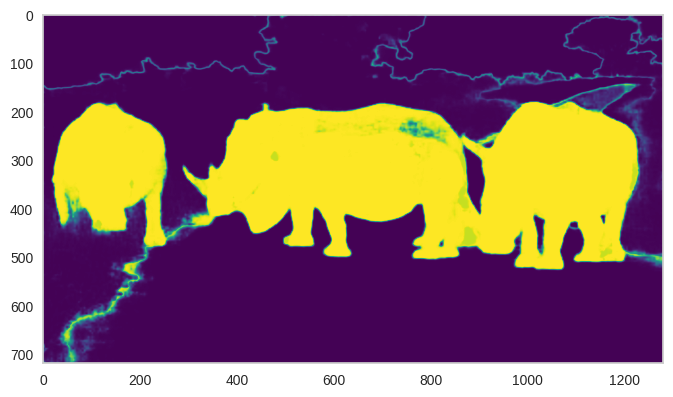

0 : pole : 41.2


<ipython-input-145-bd309ac8ecde>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(prob_logits[region_idx, :19])


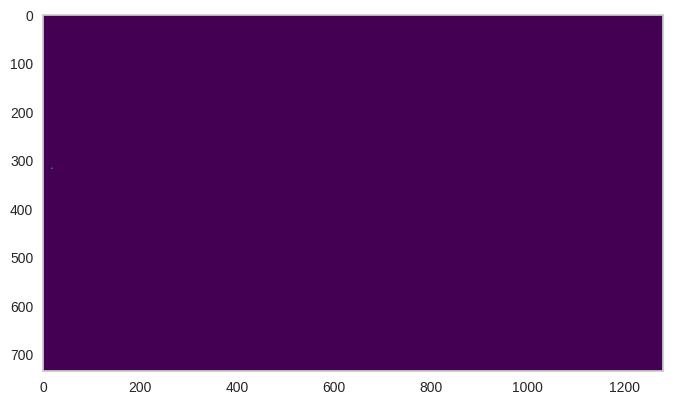

1 : pole : 22.56


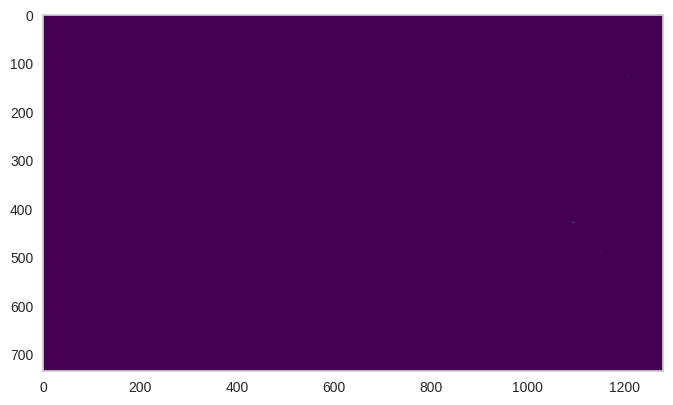

2 : pole : 38.75


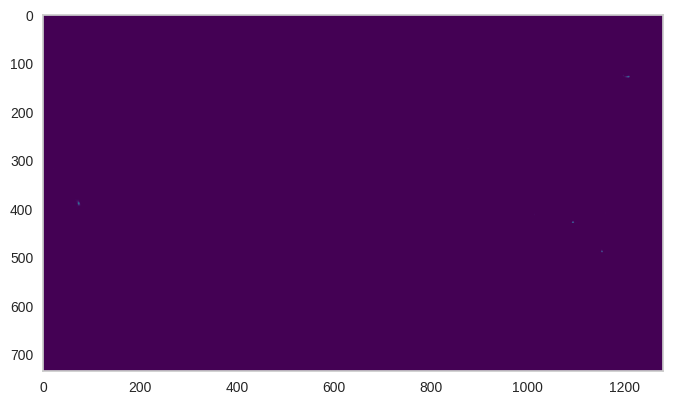

3 : sidewalk : 17.64


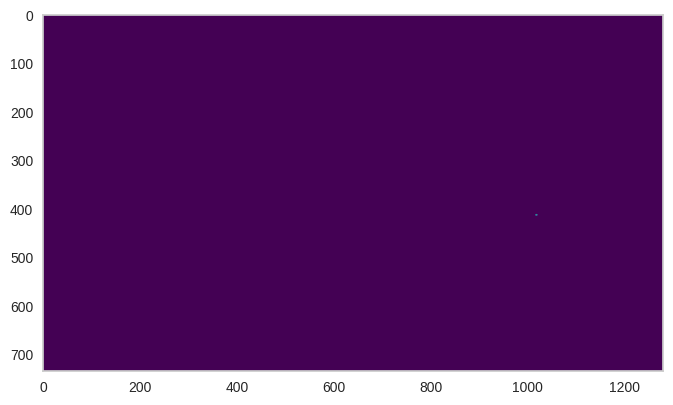

4 : pole : 44.37


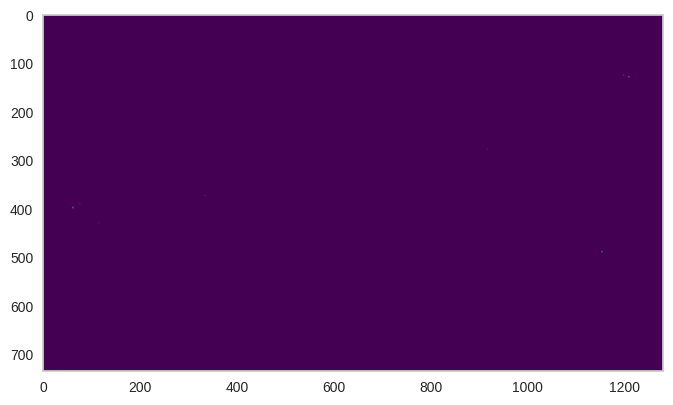

5 : pole : 14.69


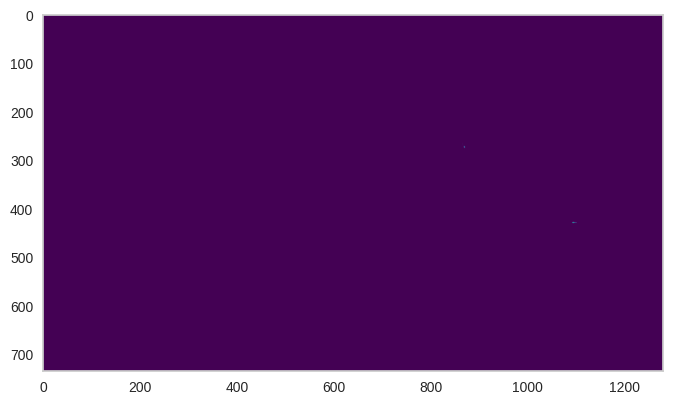

6 : vegetation : 41.37


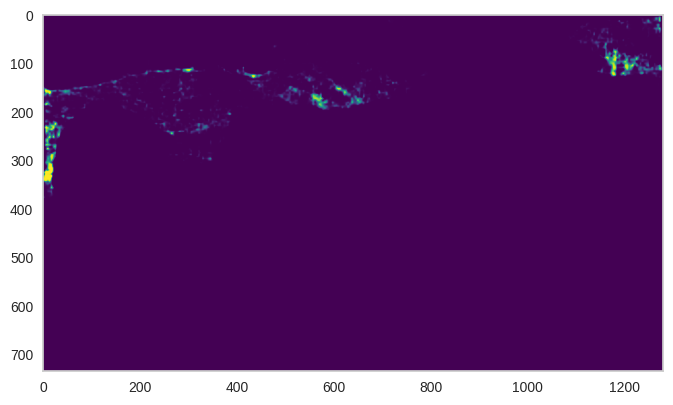

7 : person : 70.61


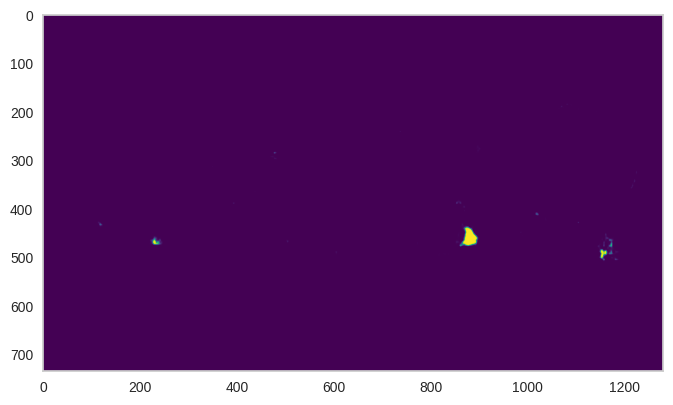

8 : wall : 91.69


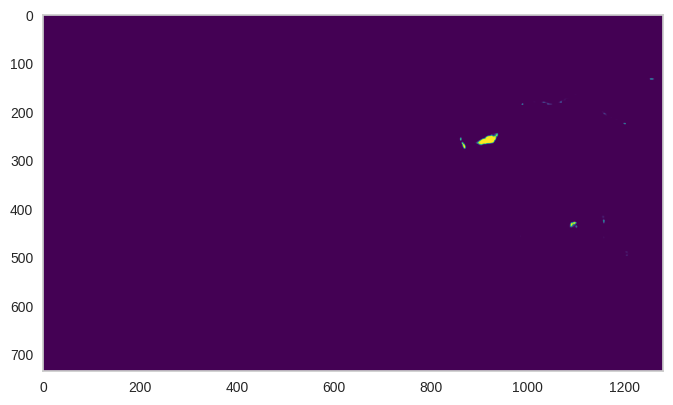

9 : pole : 40.31


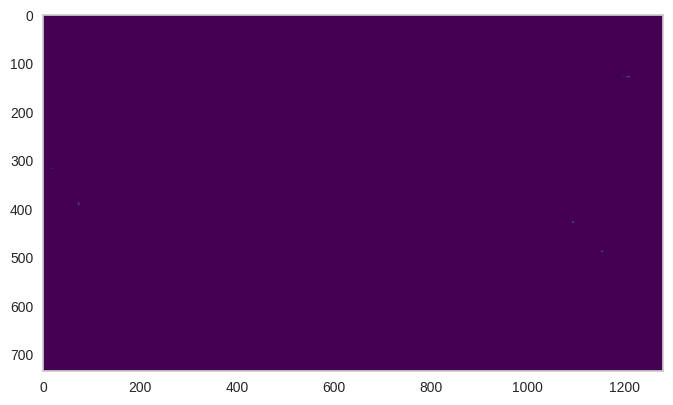

10 : building : 85.81


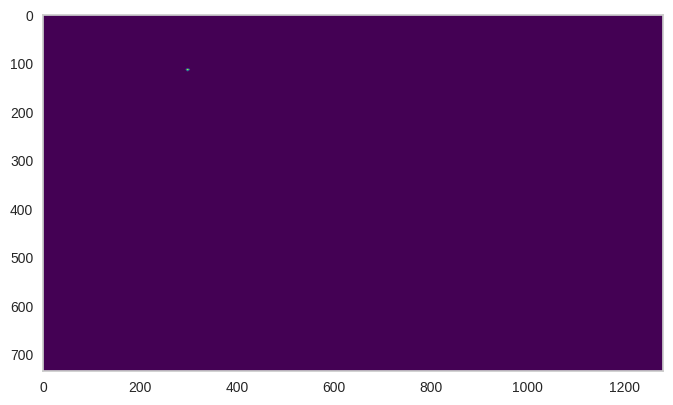

11 : sidewalk : 31.87


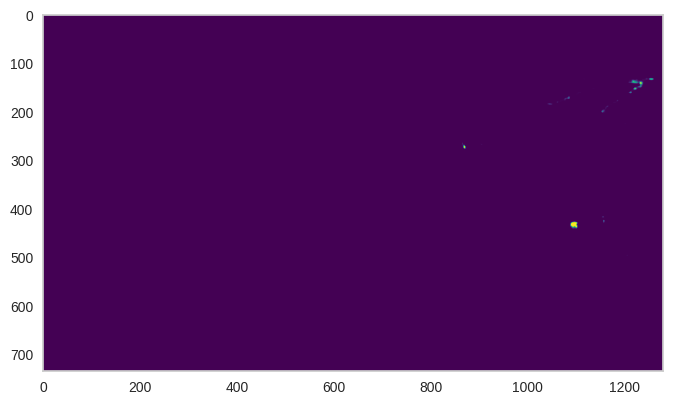

12 : building : 19.85


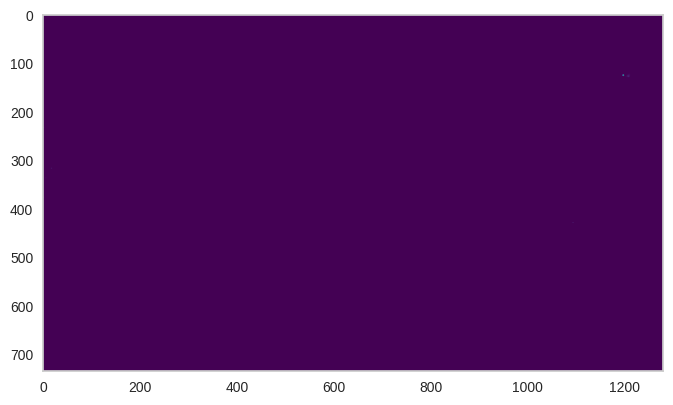

13 : pole : 57.92


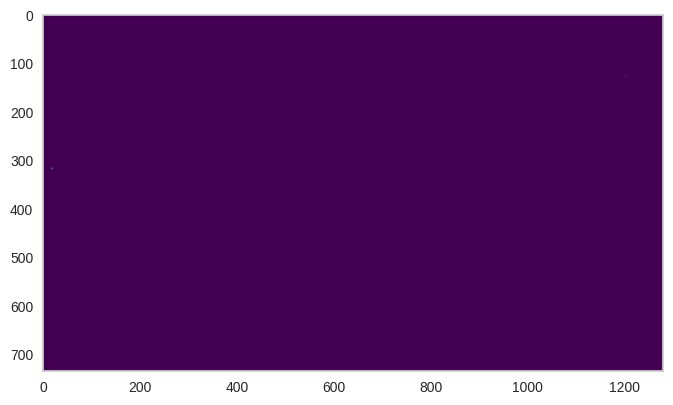

14 : sky : 99.96


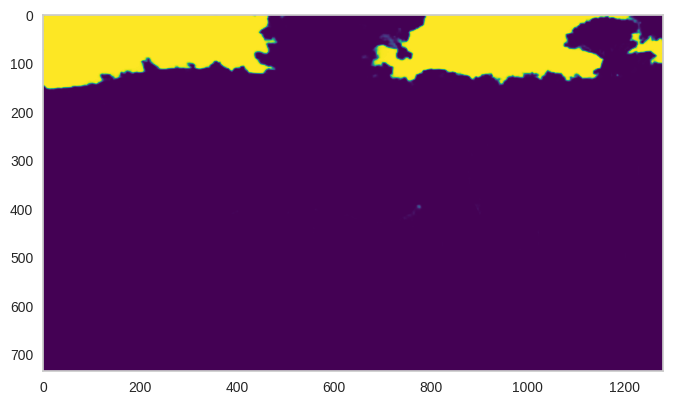

15 : pole : 19.75


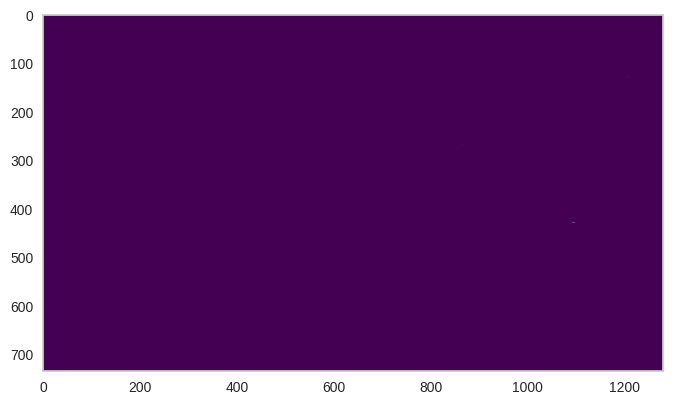

16 : building : 96.43


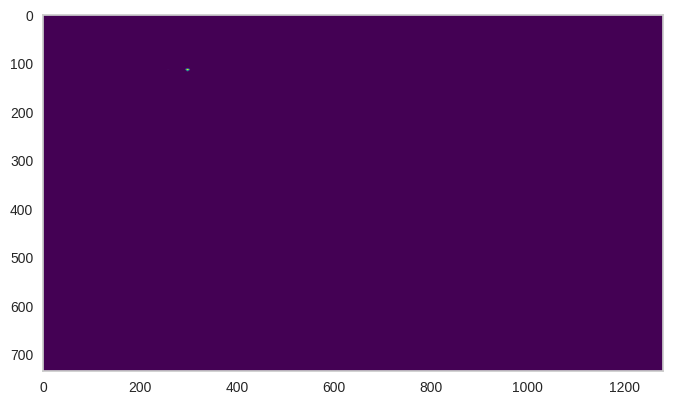

17 : car : 33.12


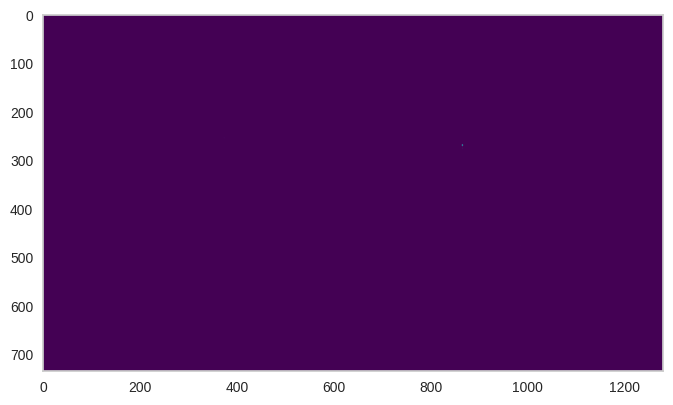

18 : person : 51.3


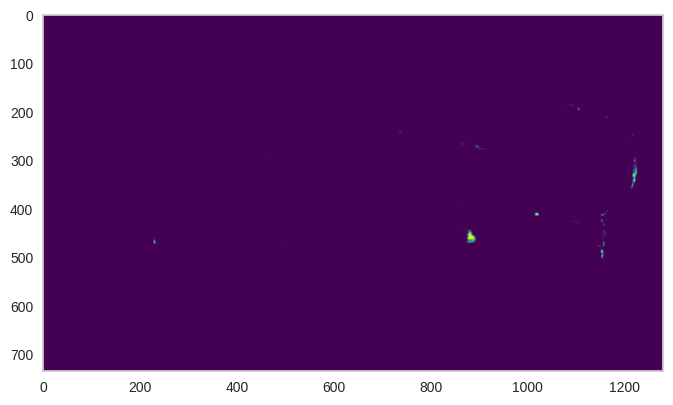

19 : sidewalk : 31.68


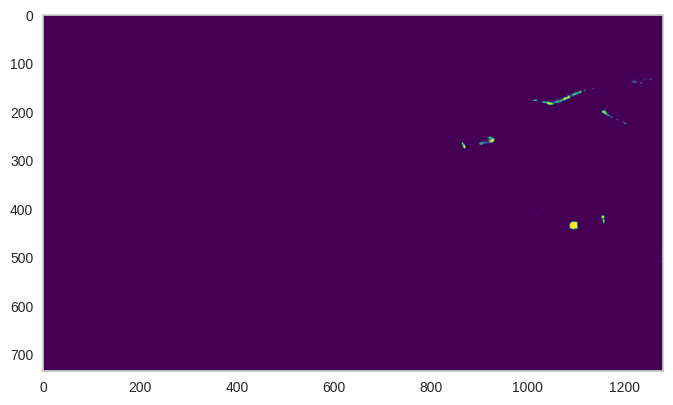

20 : road : 99.99


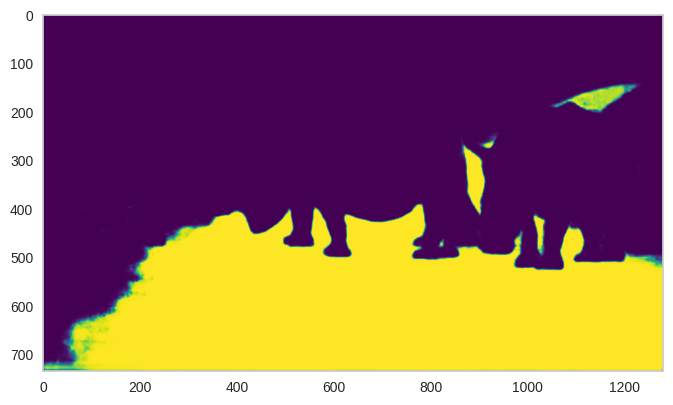

21 : person : 58.21


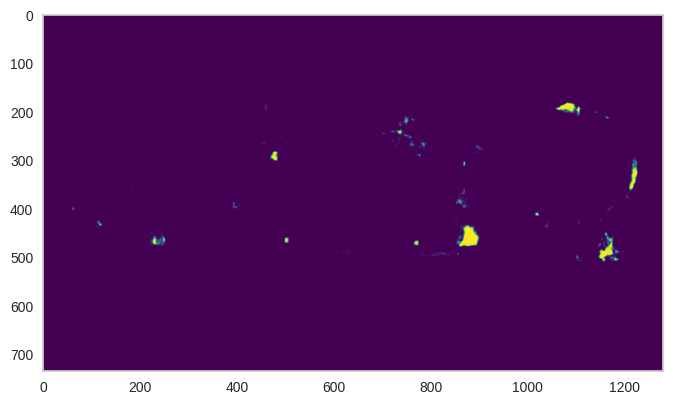

22 : person : 99.67


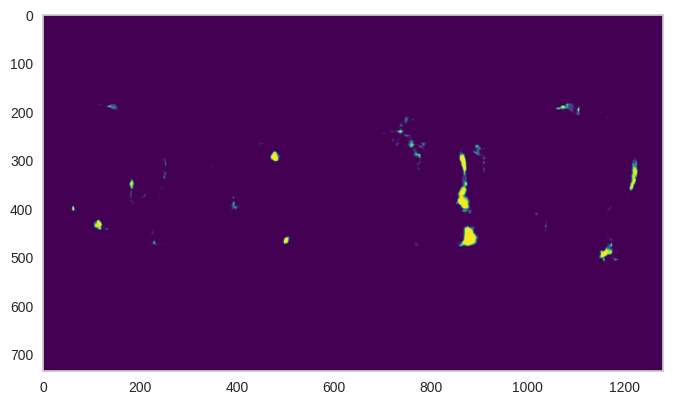

23 : pole : 19.24


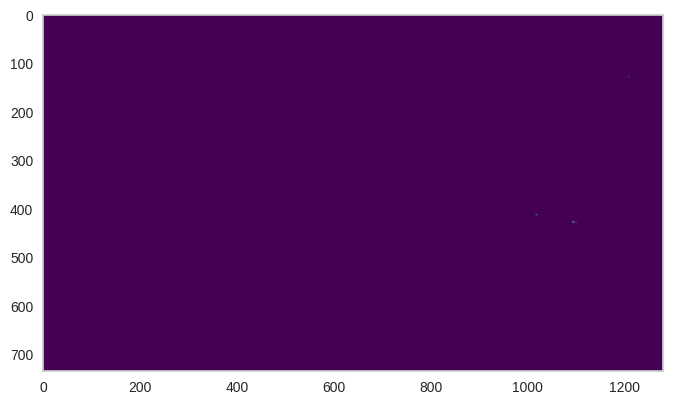

24 : sidewalk : 94.04


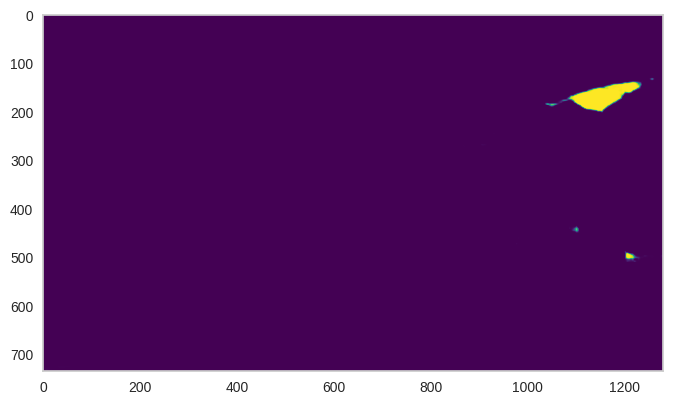

25 : pole : 39.3


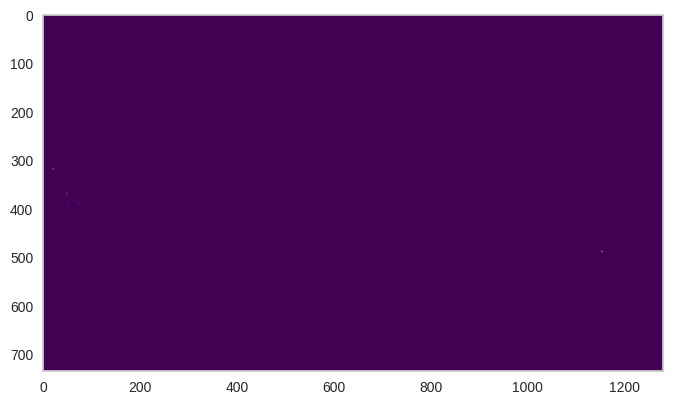

26 : pole : 38.59


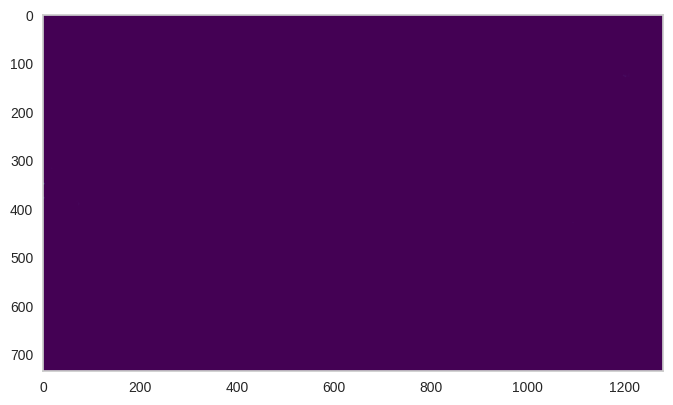

27 : pole : 37.26


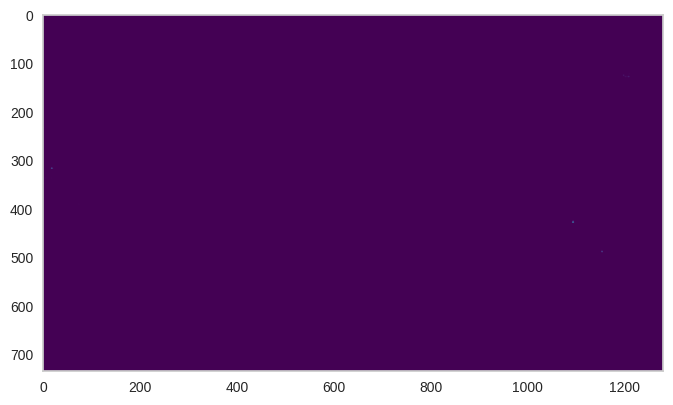

28 : pole : 54.25


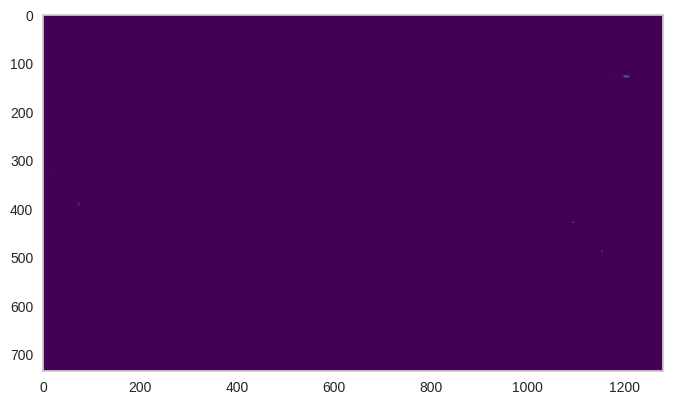

29 : person : 17.5


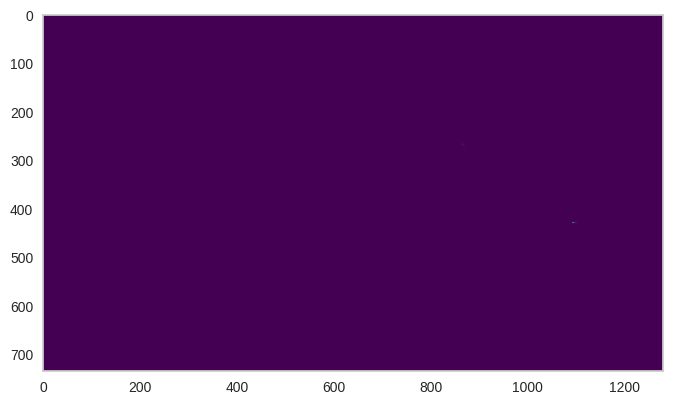

30 : person : 22.53


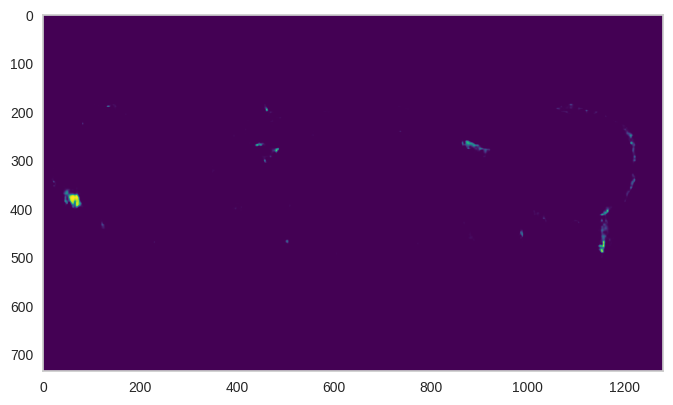

31 : rider : 28.77


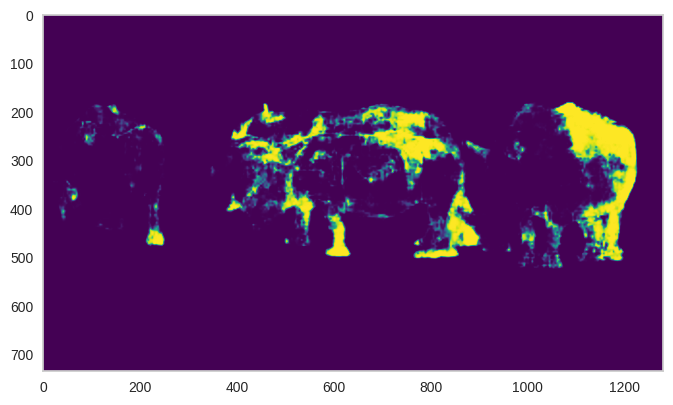

32 : bicycle : 29.62


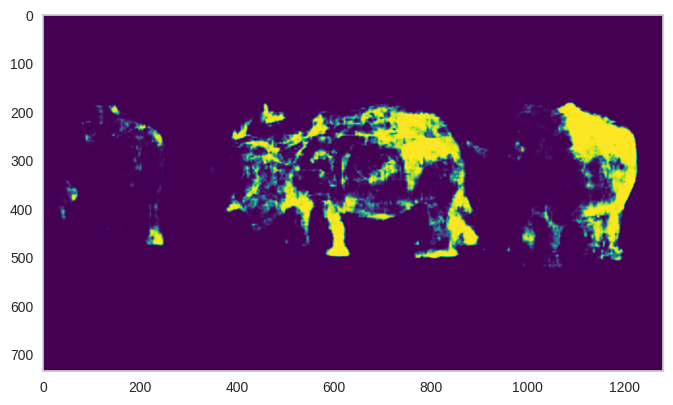

33 : traffic sign : 34.42


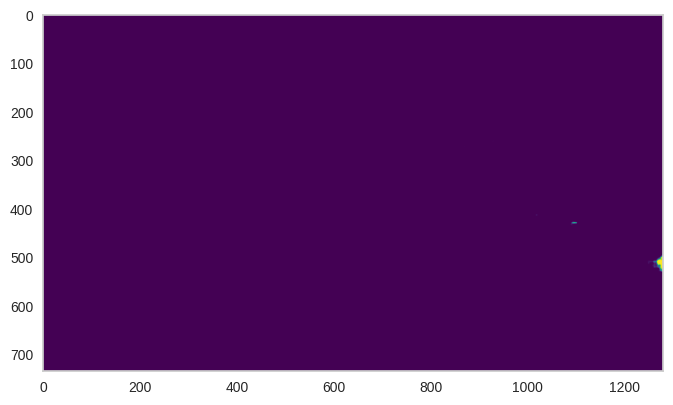

34 : vegetation : 49.71


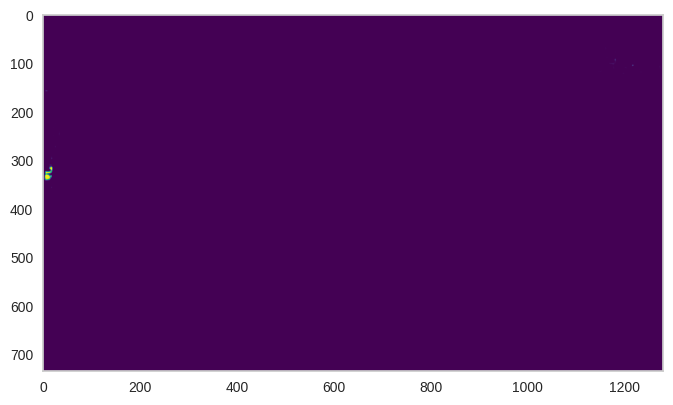

35 : pole : 47.55


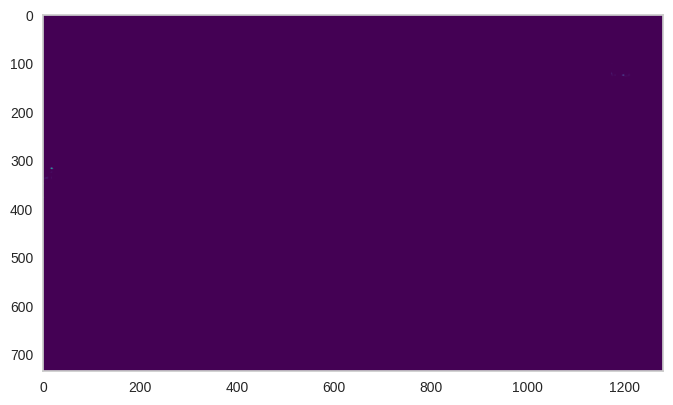

36 : pole : 27.13


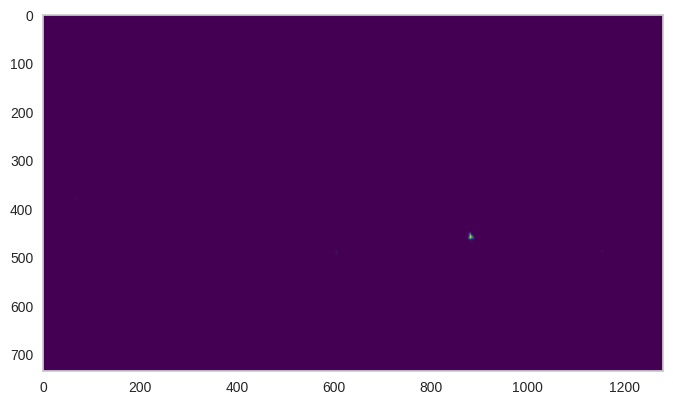

37 : pole : 48.98


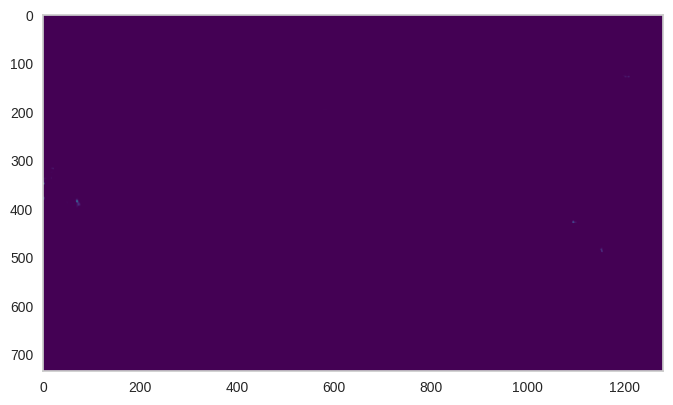

38 : wall : 16.81


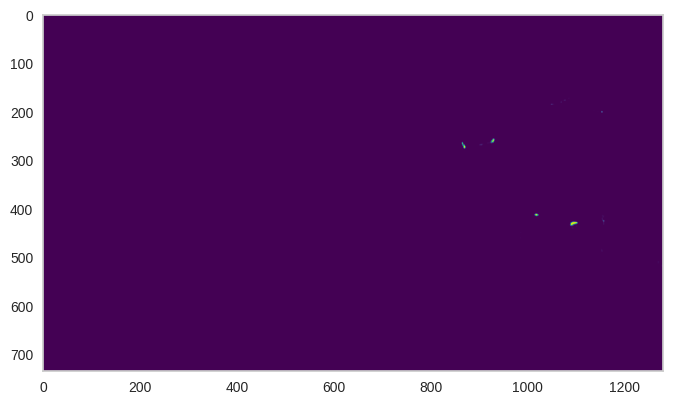

39 : rider : 18.58


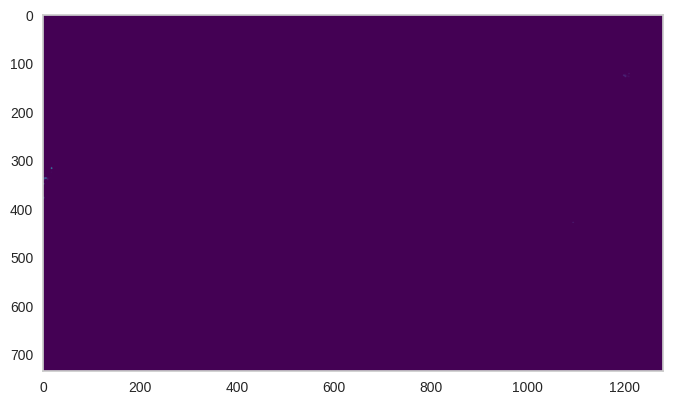

40 : pole : 14.74


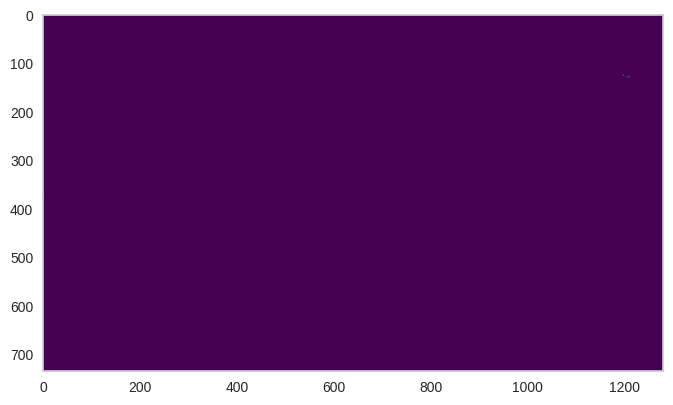

41 : pole : 42.53


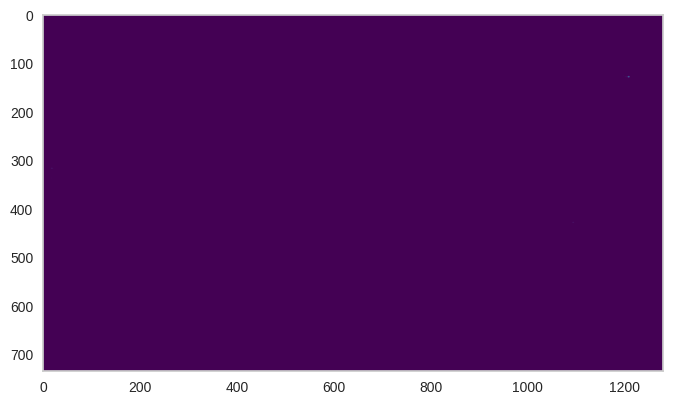

42 : sidewalk : 73.27


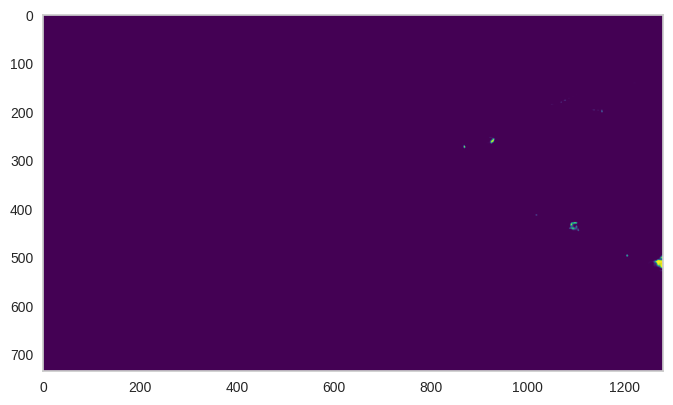

43 : car : 31.85


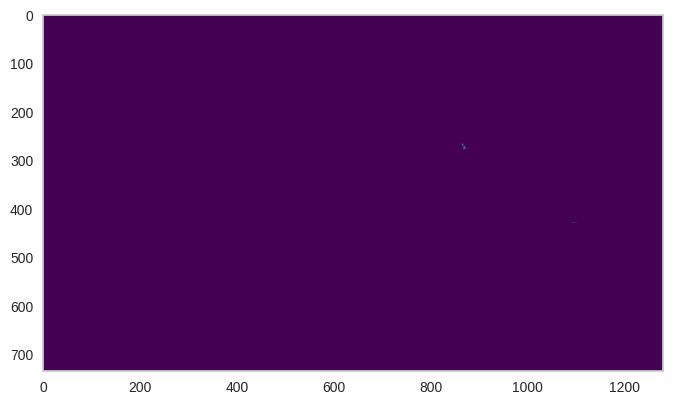

44 : person : 31.37


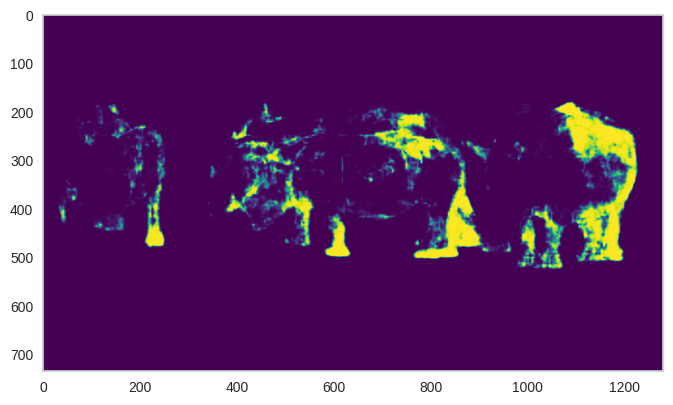

45 : person : 24.47


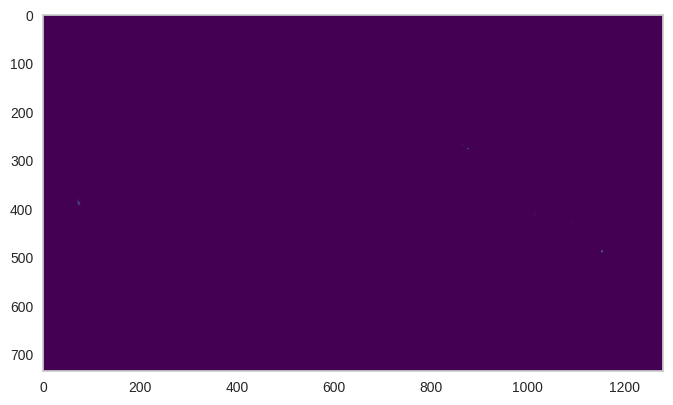

46 : vegetation : 34.89


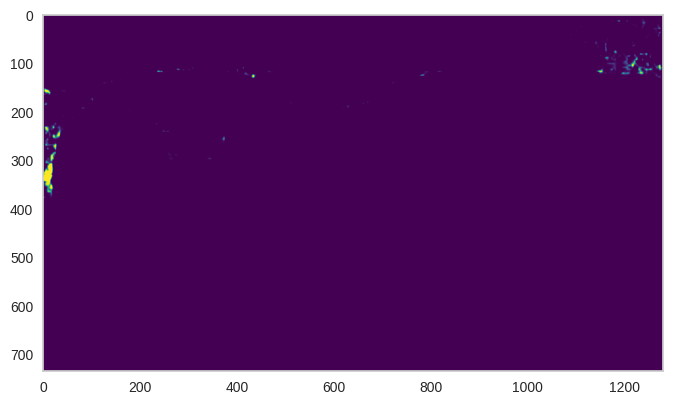

47 : pole : 46.25


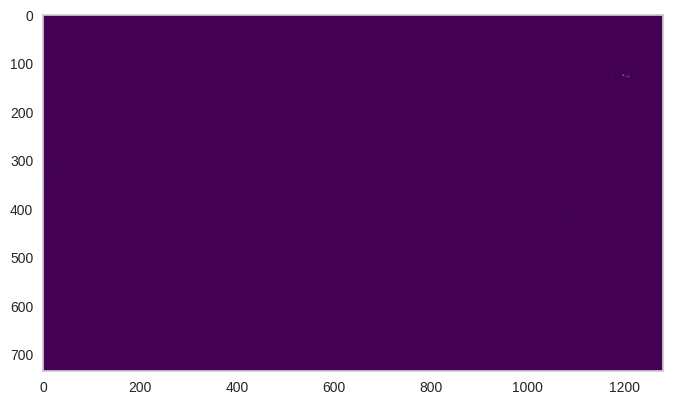

48 : vegetation : 44.28


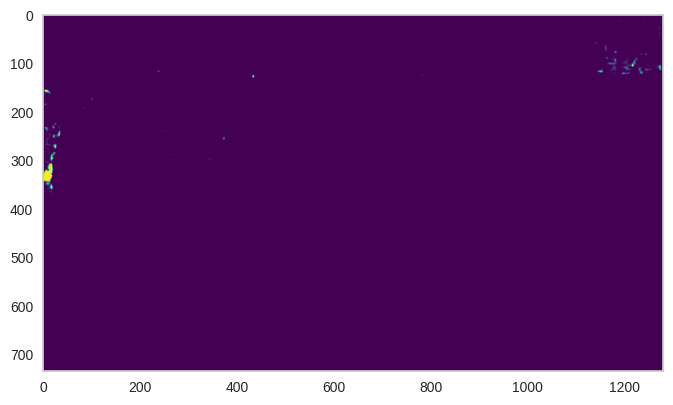

49 : bicycle : 27.8


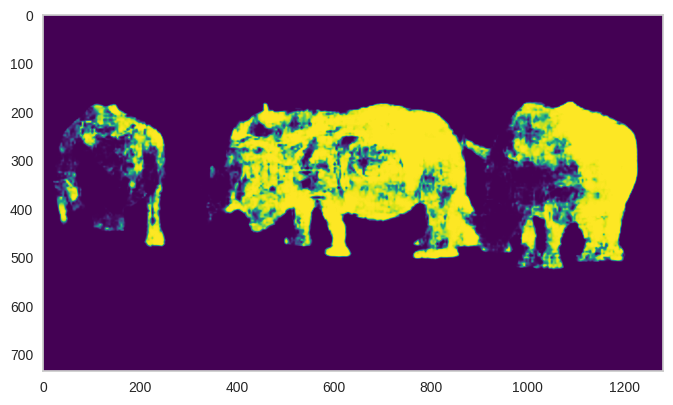

50 : person : 47.58


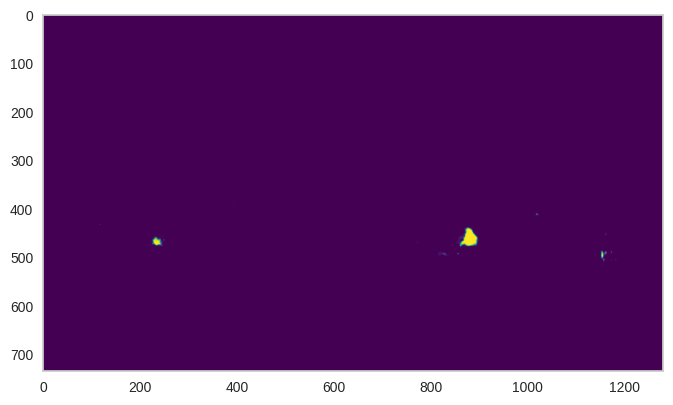

51 : person : 36.88


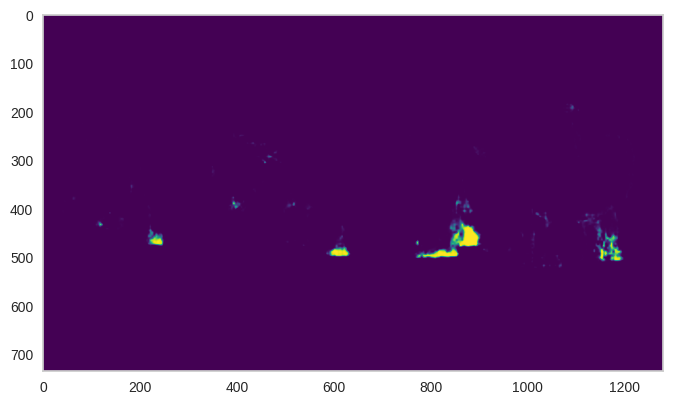

52 : sidewalk : 97.56


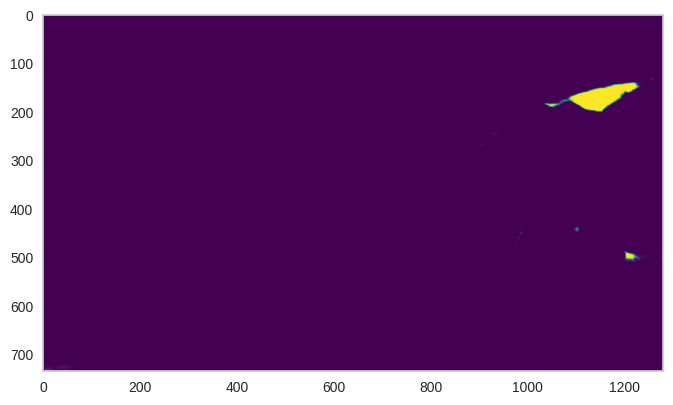

53 : pole : 26.99


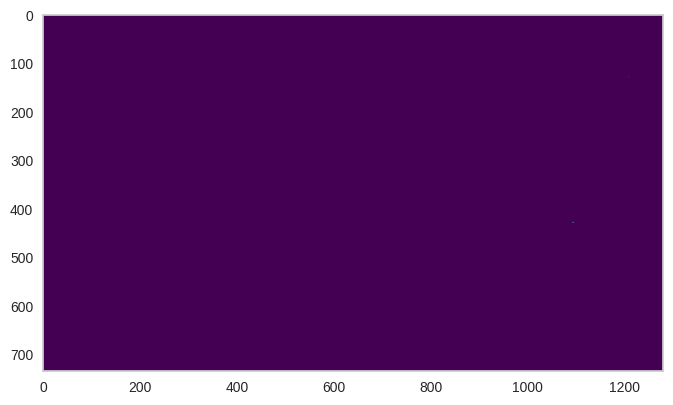

54 : pole : 34.17


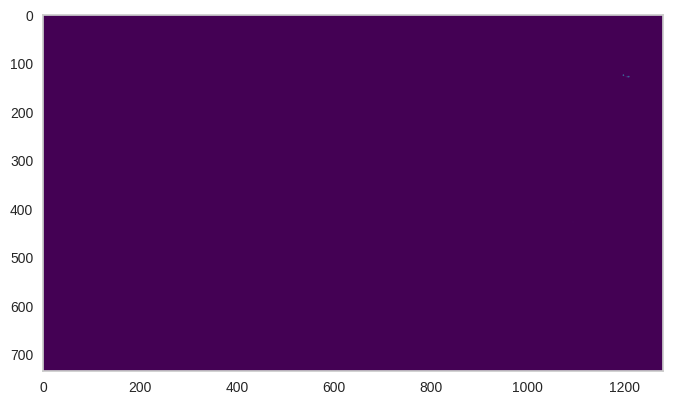

55 : pole : 27.89


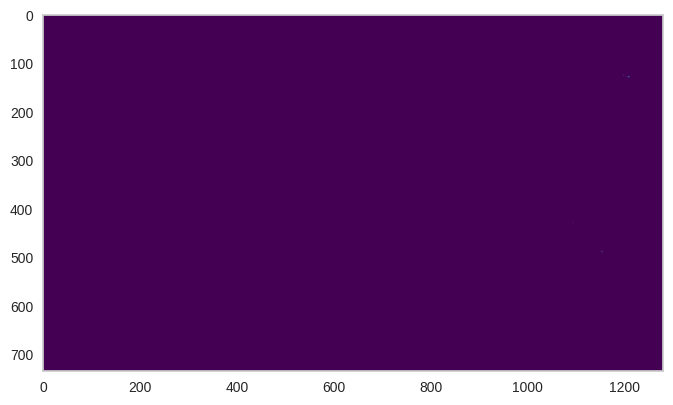

56 : person : 47.37


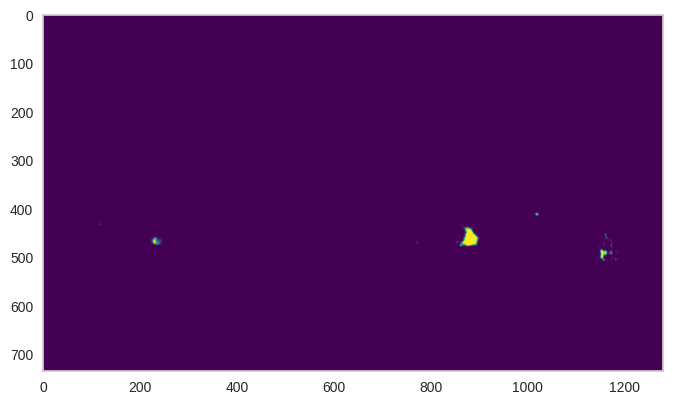

57 : pole : 50.3


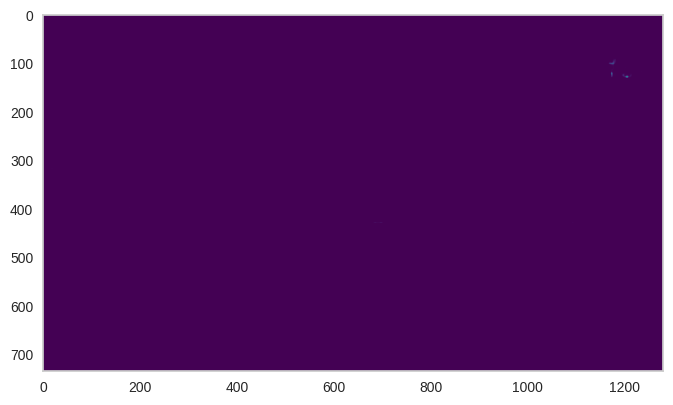

58 : sidewalk : 40.4


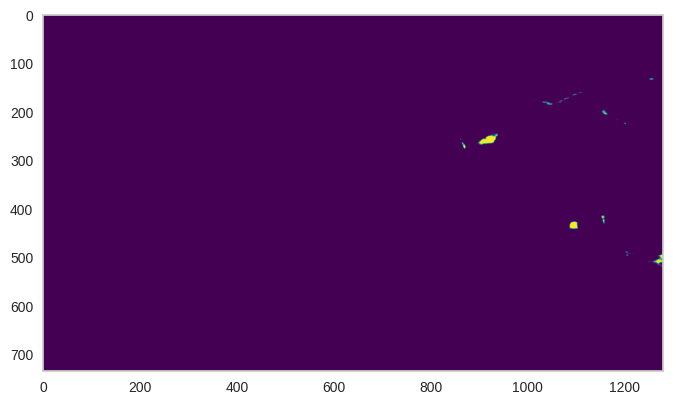

59 : pole : 30.09


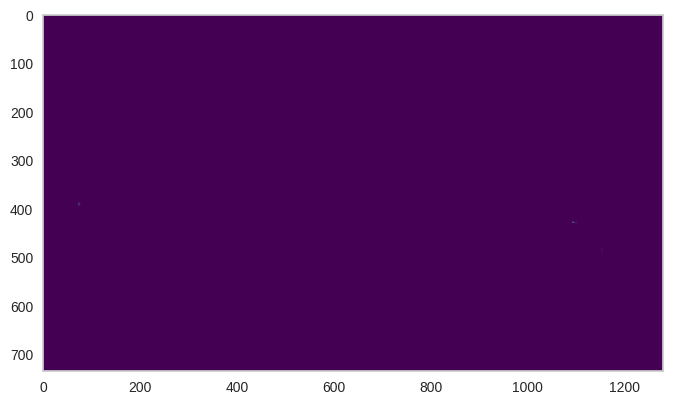

60 : pole : 43.5


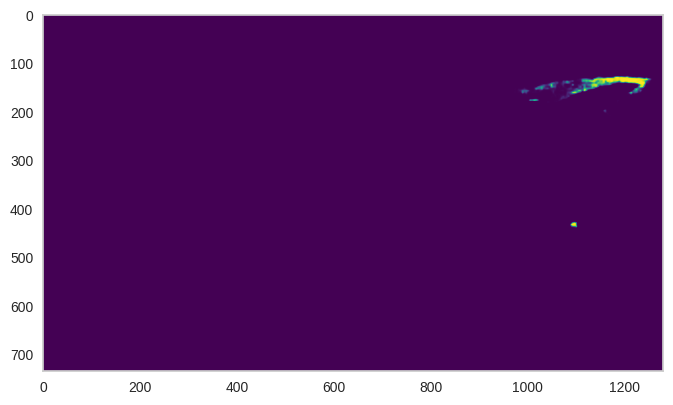

61 : car : 17.83


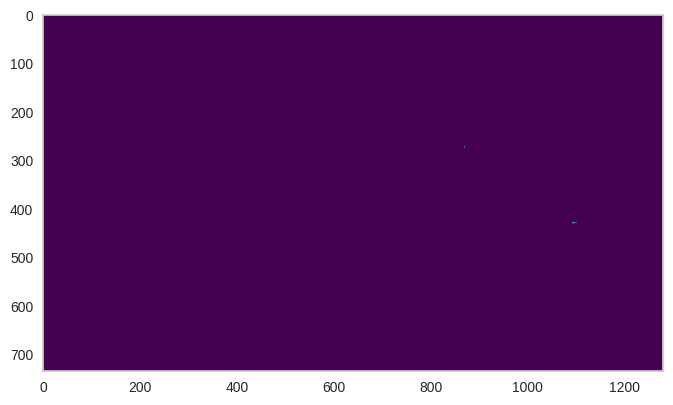

62 : sidewalk : 16.93


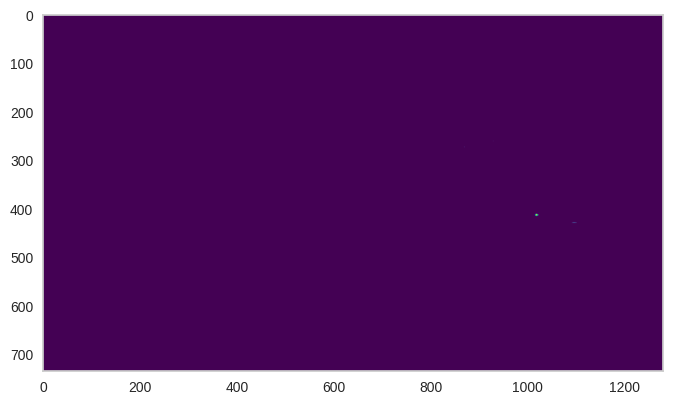

63 : sidewalk : 15.37


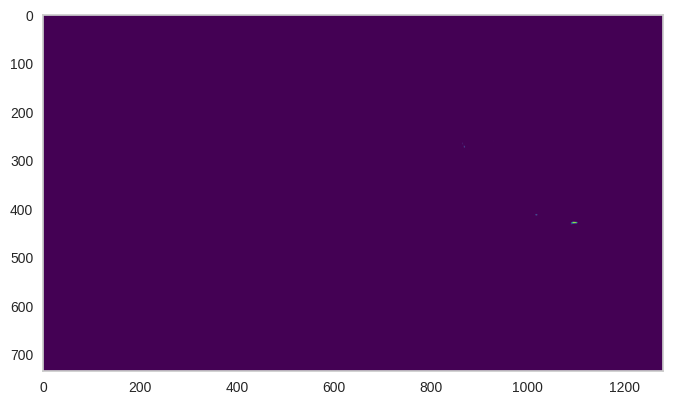

64 : bicycle : 23.05


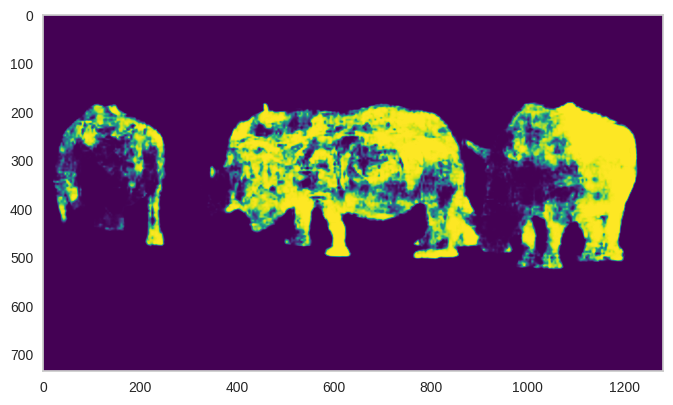

65 : pole : 45.87


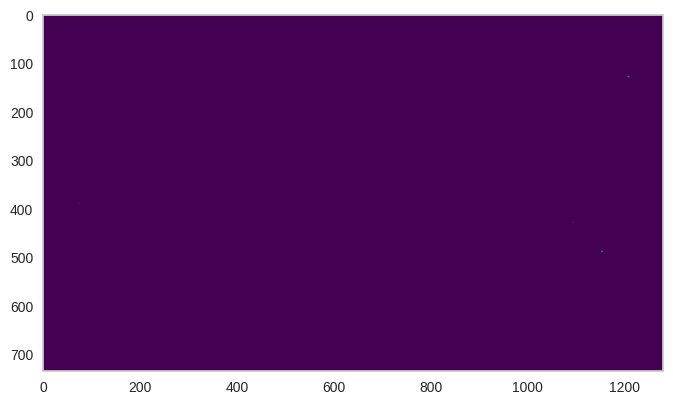

66 : pole : 59.95


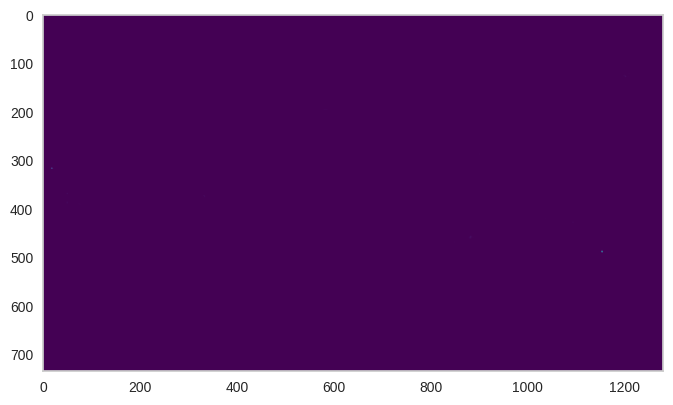

67 : person : 75.99


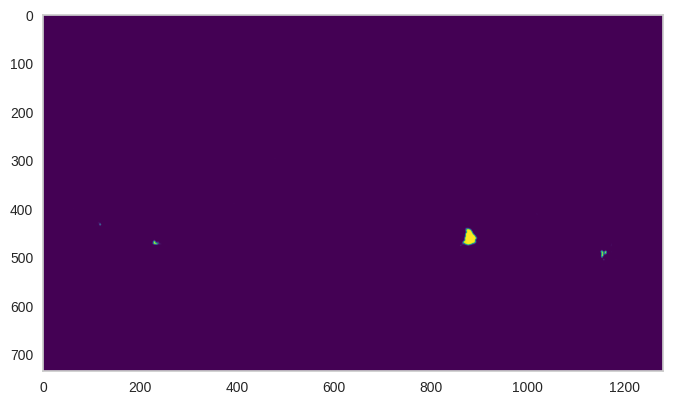

68 : pole : 41.46


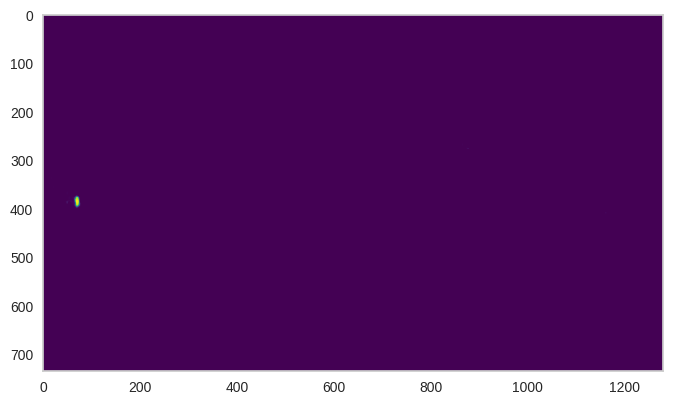

69 : pole : 16.09


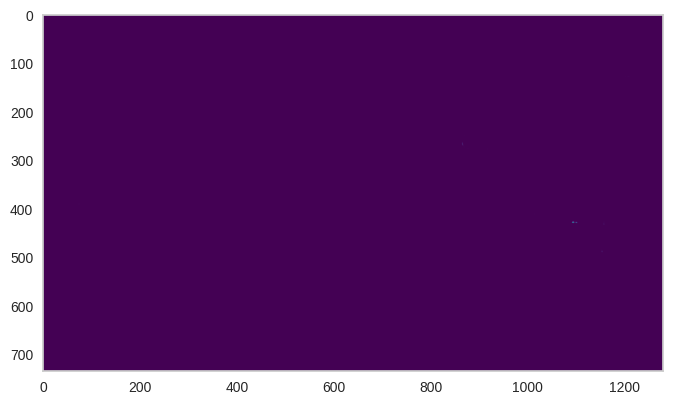

70 : pole : 36.87


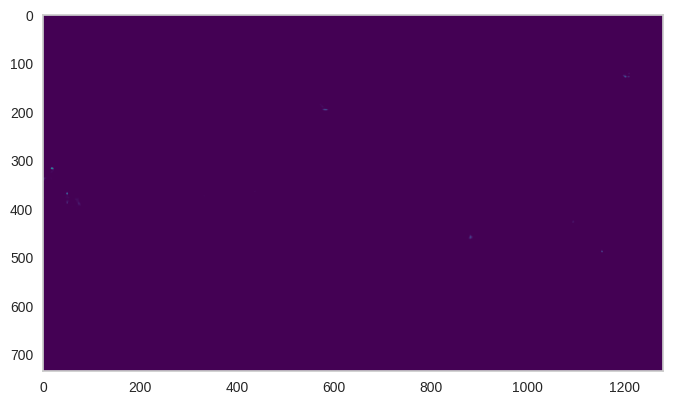

71 : person : 16.55


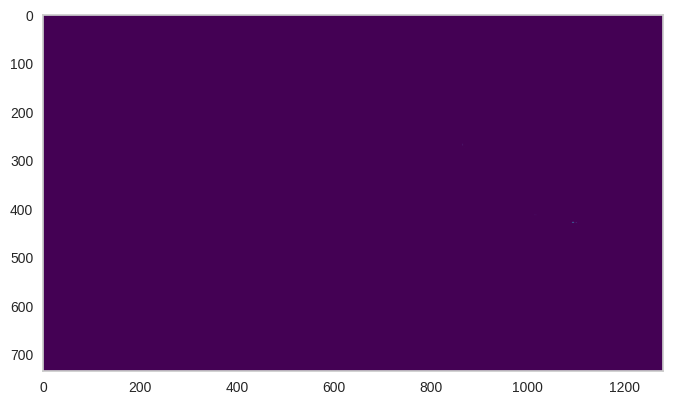

72 : person : 53.85


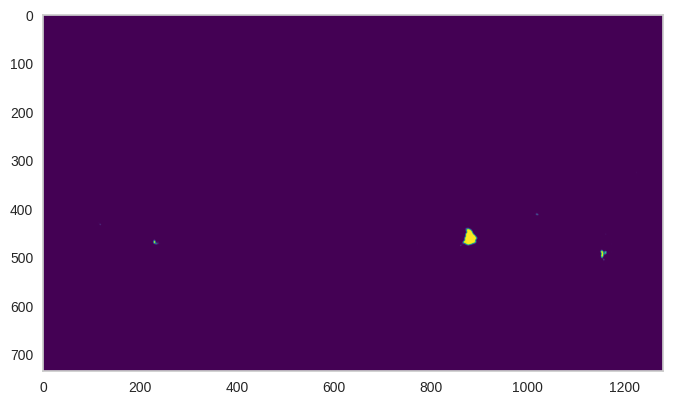

73 : pole : 27.66


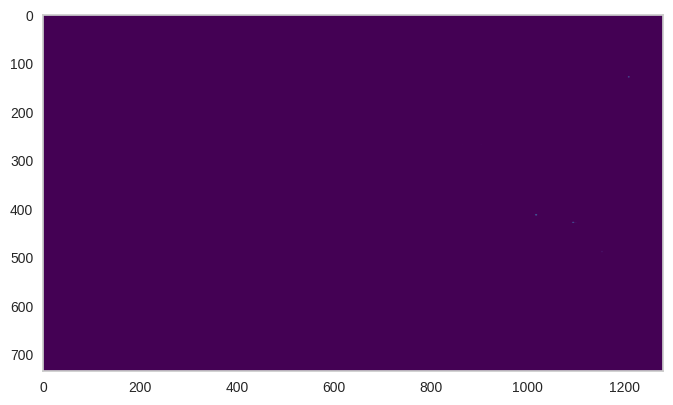

74 : wall : 37.35


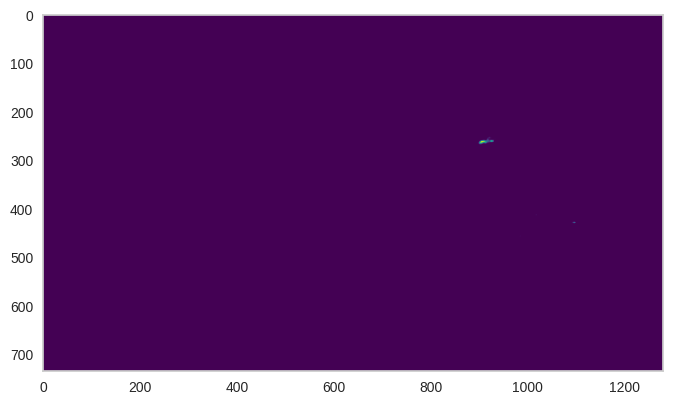

75 : person : 76.82


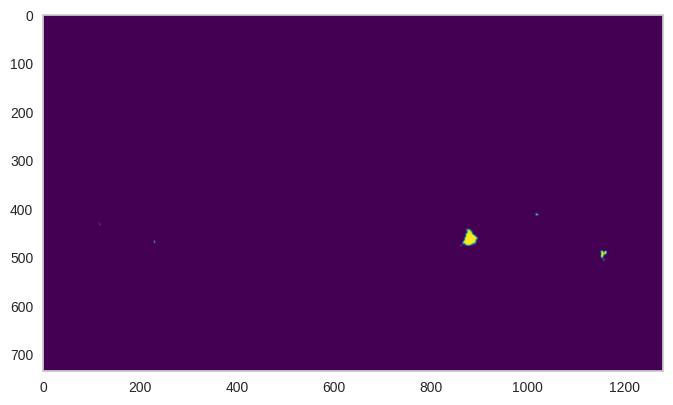

76 : building : 22.29


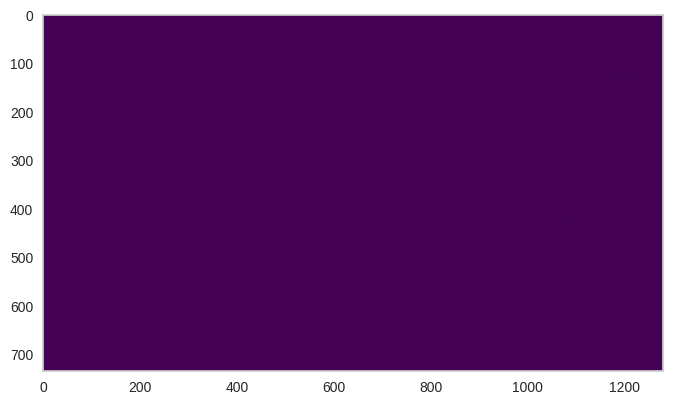

77 : pole : 80.39


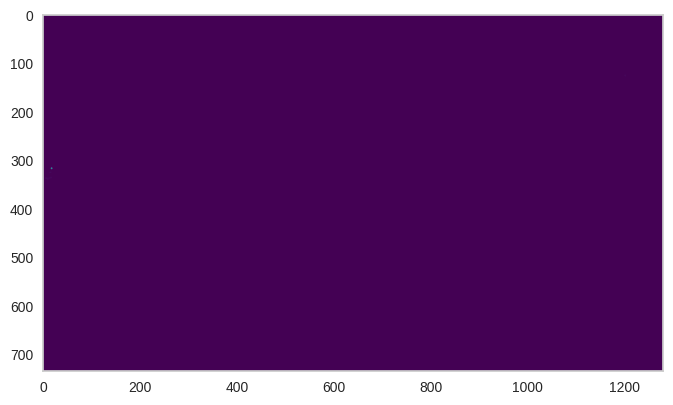

78 : sidewalk : 16.09


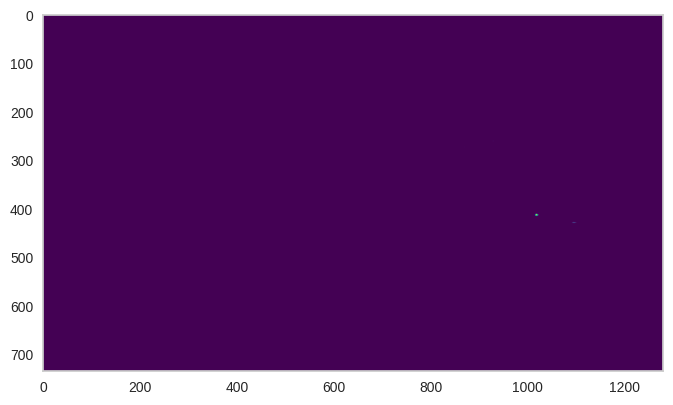

79 : pole : 46.89


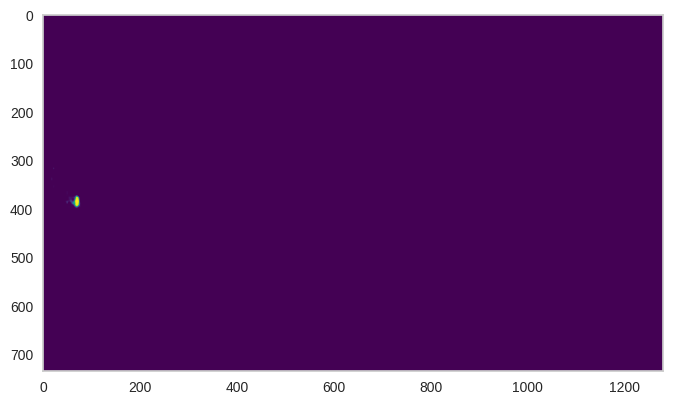

80 : pole : 38.75


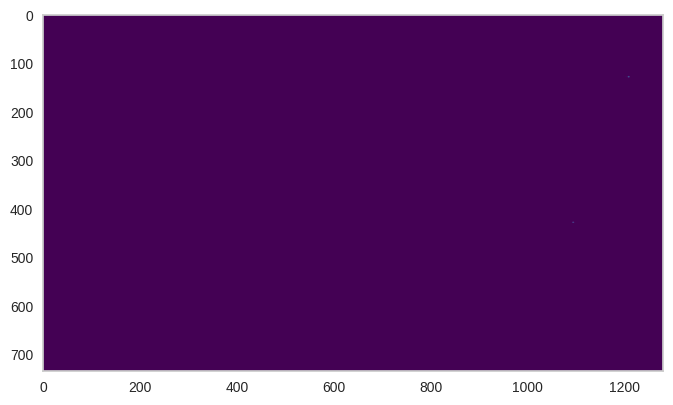

81 : sidewalk : 64.21


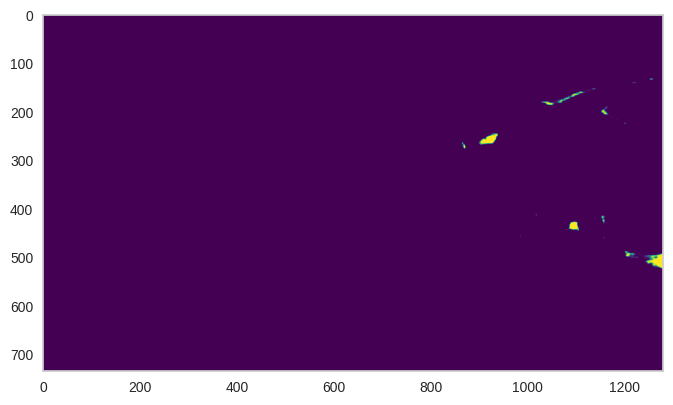

82 : sidewalk : 96.77


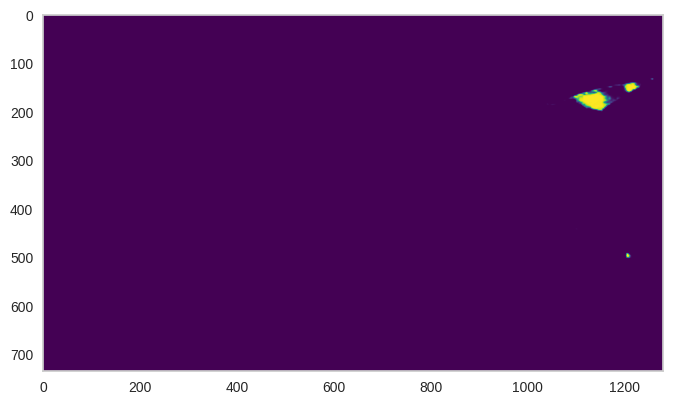

83 : person : 31.99


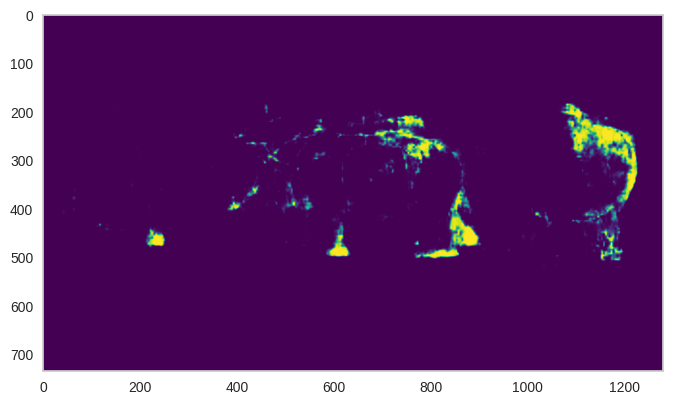

84 : terrain : 55.47


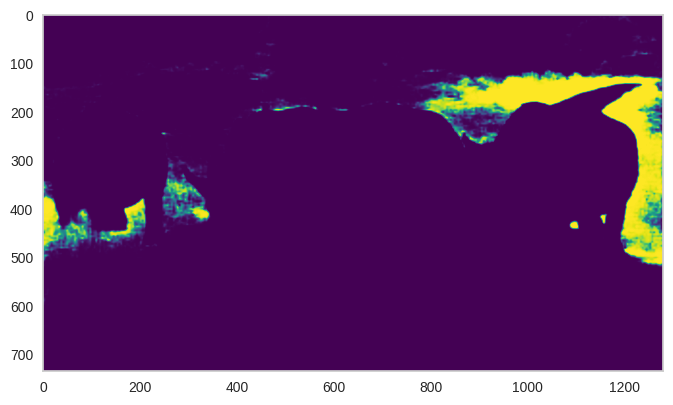

85 : car : 28.76


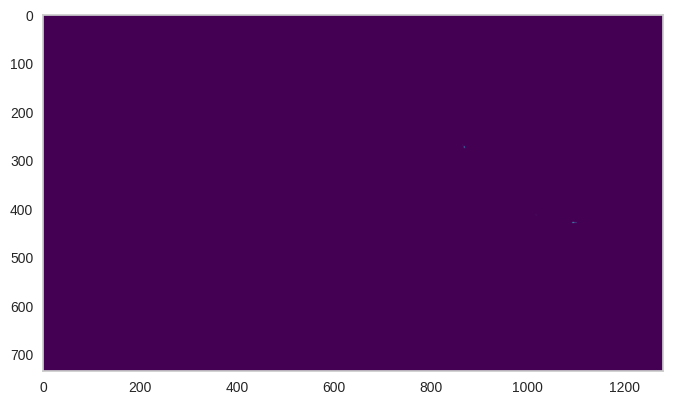

86 : car : 23.58


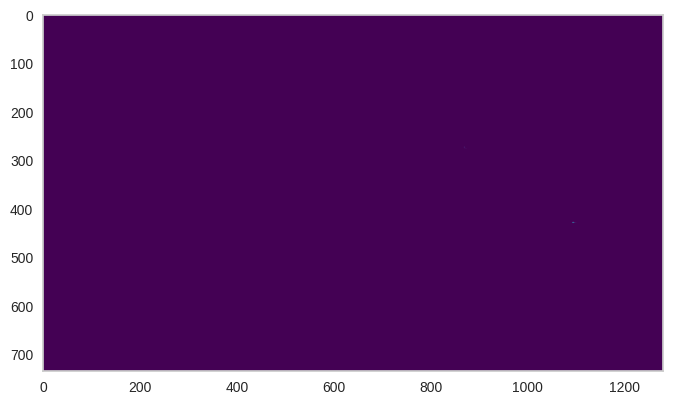

87 : pole : 24.23


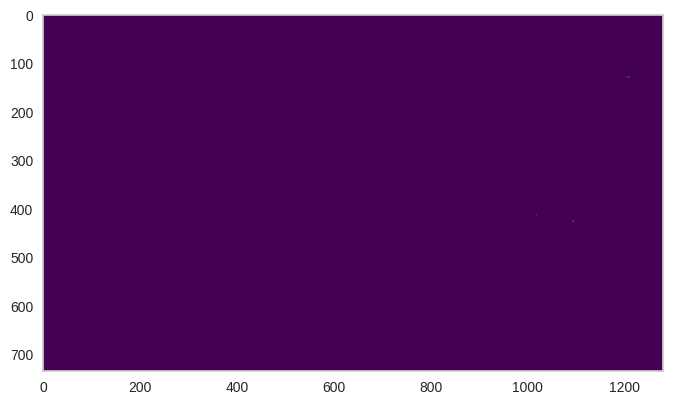

88 : pole : 80.96


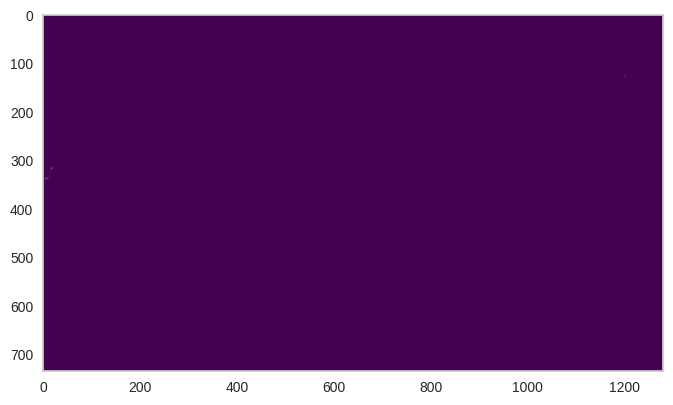

89 : person : 75.7


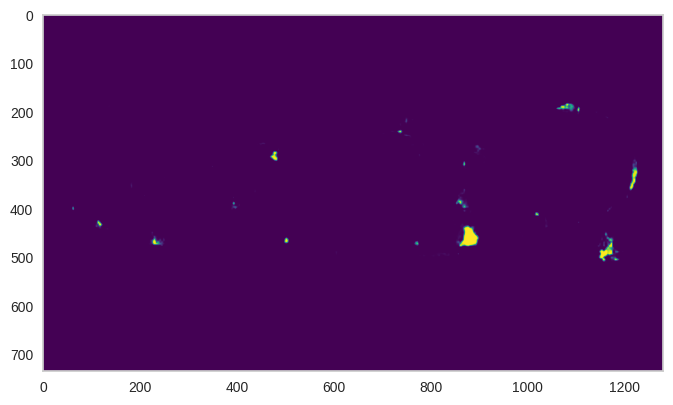

90 : terrain : 43.93


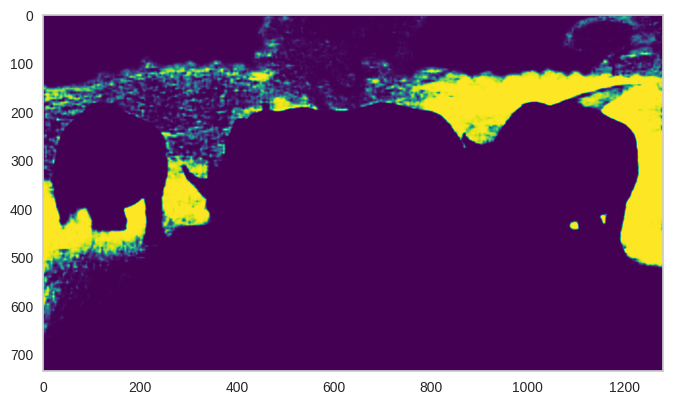

91 : person : 56.37


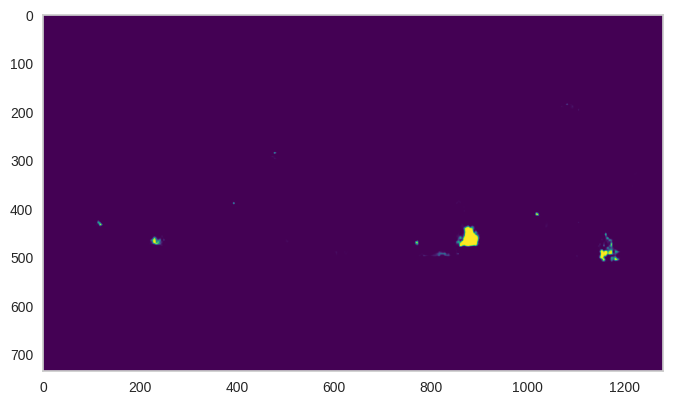

92 : terrain : 99.99


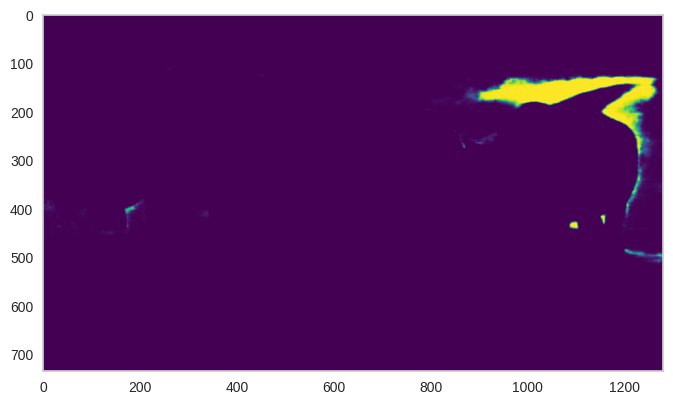

93 : vegetation : 100.0


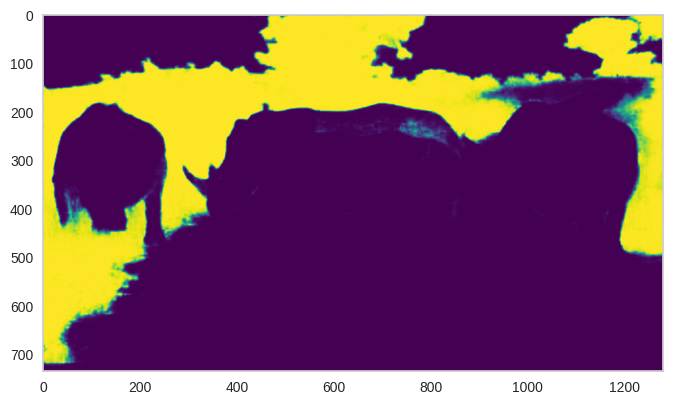

94 : person : 57.57


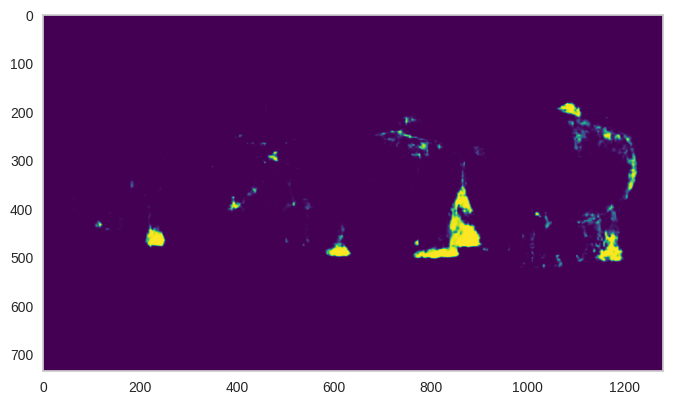

95 : pole : 52.82


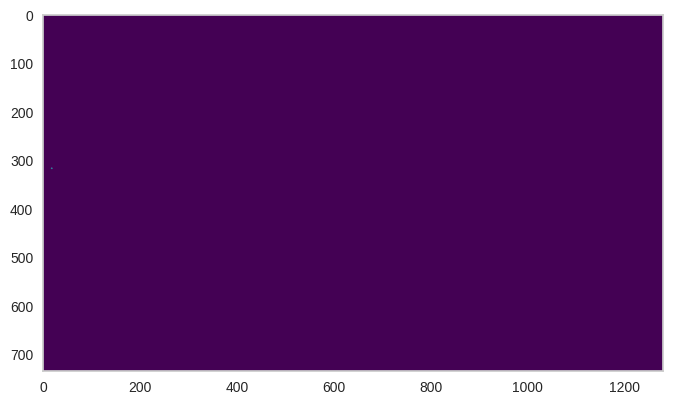

96 : pole : 35.69


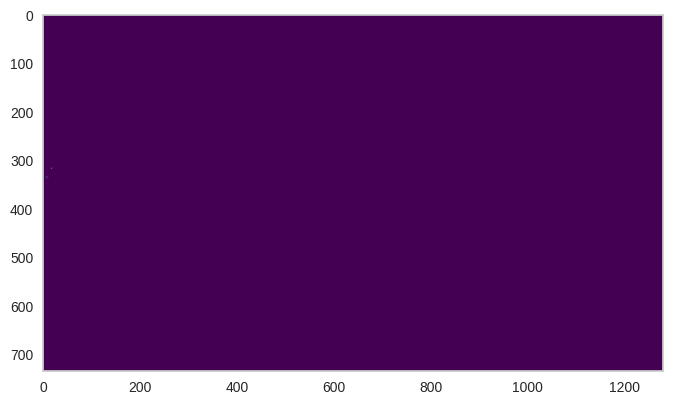

97 : building : 19.66


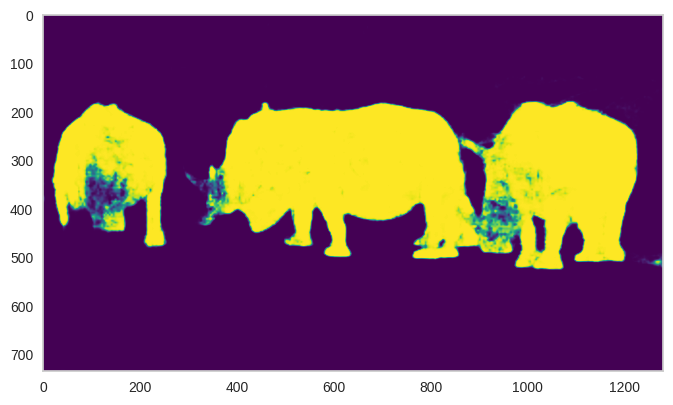

98 : person : 25.28


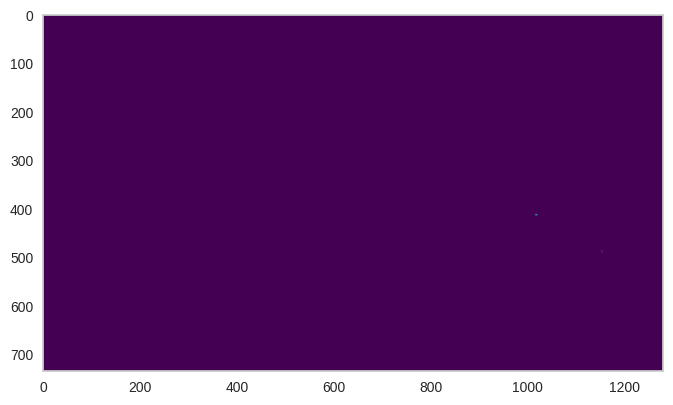

99 : pole : 34.07


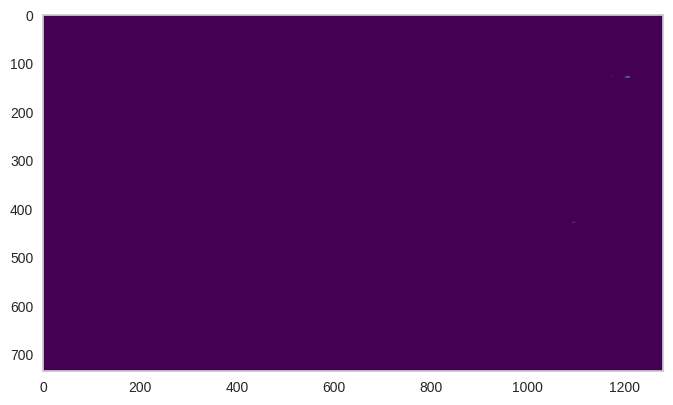

Sum of Masks


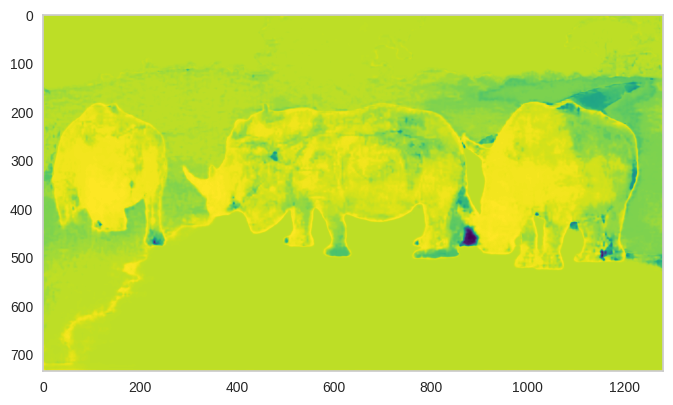

In [145]:
plt.imshow(-logits.cpu().squeeze()[:19].max(dim=0).values)
plt.show()

sum_of_masks = torch.zeros((736, 1280))

for region_idx in range(100):
    probs = F.softmax(prob_logits[region_idx, :19])
    cls = torch.argmax(probs)
#     if probs[cls].item() < 0.8:
#         continue
    
    if cls < 19:
        print(region_idx, ":", bdd100k_dataset.class_names[cls], ":", np.round(probs[cls].item() * 100, 2))
    else:
        #continue
        print(region_idx, ":", "no-Object")
    
    mask_normalized = torch.sigmoid(mask_logits[region_idx].cpu())
    plt.imshow(mask_normalized)
    plt.show()
    
    #if probs[cls].item() > 0.0:
    sum_of_masks += mask_normalized * probs[cls].item()
    
print("Sum of Masks")
plt.imshow(-sum_of_masks)
plt.show()